In [261]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import numpy as np

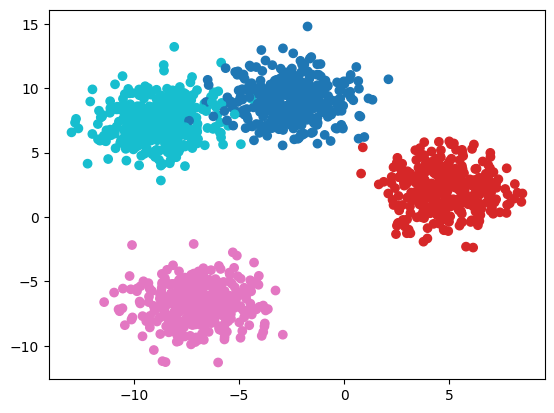

In [262]:
X_blob, y_blob = make_blobs(n_samples=1500, n_features=2, centers=4, cluster_std=1.5, random_state=42)

X_blob = torch.from_numpy(X_blob).type(torch.float)
# Convert labels from NumPy array to PyTorch LongTensor (int64), 
# because CrossEntropyLoss expects class indices in integer format, not floats
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

X_blob_train, X_blob_test = X_blob_train.to(device), X_blob_test.to(device) 
y_blob_train, y_blob_test = y_blob_train.to(device), y_blob_test.to(device)

plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap='tab10')
plt.show()


In [263]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred)
    correct_counts = correct.sum().item()
    acc = (correct_counts / len(y_pred)) * 100
    return acc

In [264]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)
    
model = BlobModel(input_features=2,
                  output_features=4,
                  hidden_units=8).to(device)

In [265]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

epochs = 100


for epoch in range(epochs):
    model.train()

    y_logits = model(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.inference_mode():
        y_test_logits = model(X_blob_test)
        test_pred = torch.softmax(y_test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(y_test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_pred)
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch: {epoch+1} | Loss: {loss:.4f} | acc: {acc:.2f}% | Test Loss: {test_loss:.4f} | Test acc: {test_acc:.2f}%')



Epoch: 10 | Loss: 0.6750 | acc: 96.25% | Test Loss: 0.6511 | Test acc: 94.67%
Epoch: 20 | Loss: 0.4470 | acc: 98.83% | Test Loss: 0.4246 | Test acc: 98.67%
Epoch: 30 | Loss: 0.2540 | acc: 99.00% | Test Loss: 0.2280 | Test acc: 99.00%
Epoch: 40 | Loss: 0.1096 | acc: 99.08% | Test Loss: 0.0919 | Test acc: 99.00%
Epoch: 50 | Loss: 0.0679 | acc: 99.08% | Test Loss: 0.0567 | Test acc: 99.00%
Epoch: 60 | Loss: 0.0535 | acc: 99.08% | Test Loss: 0.0449 | Test acc: 98.67%
Epoch: 70 | Loss: 0.0464 | acc: 99.08% | Test Loss: 0.0388 | Test acc: 99.00%
Epoch: 80 | Loss: 0.0425 | acc: 99.08% | Test Loss: 0.0355 | Test acc: 99.00%
Epoch: 90 | Loss: 0.0400 | acc: 99.08% | Test Loss: 0.0333 | Test acc: 99.00%
Epoch: 100 | Loss: 0.0383 | acc: 99.08% | Test Loss: 0.0319 | Test acc: 99.00%


In [266]:
model.eval()
with torch.inference_mode():
    y_logits = model(X_blob_test)

y_logits [:5]

tensor([[-2.3628, -5.7659, -2.6692,  2.6871],
        [-0.4870,  3.4831, -4.1237, -4.8963],
        [-2.9246, -3.3801,  2.8558, -2.3016],
        [-0.3179,  5.5965, -7.9407, -8.5539],
        [-1.8533, -6.7638, -4.6350,  3.0116]], device='cuda:0')

In [267]:
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:5]

tensor([[6.3380e-03, 2.1087e-04, 4.6652e-03, 9.8879e-01],
        [1.8509e-02, 9.8078e-01, 4.8750e-04, 2.2514e-04],
        [3.0546e-03, 1.9370e-03, 9.8931e-01, 5.6952e-03],
        [2.6932e-03, 9.9730e-01, 1.3174e-06, 7.1352e-07],
        [7.6492e-03, 5.6367e-05, 4.7377e-04, 9.9182e-01]], device='cuda:0')

In [268]:
y_pred = y_pred_probs.argmax(dim=1)
y_pred[:10], y_blob_test[:10]

(tensor([3, 1, 2, 1, 3, 2, 0, 2, 2, 2], device='cuda:0'),
 tensor([3, 1, 2, 1, 3, 2, 0, 2, 2, 2], device='cuda:0'))

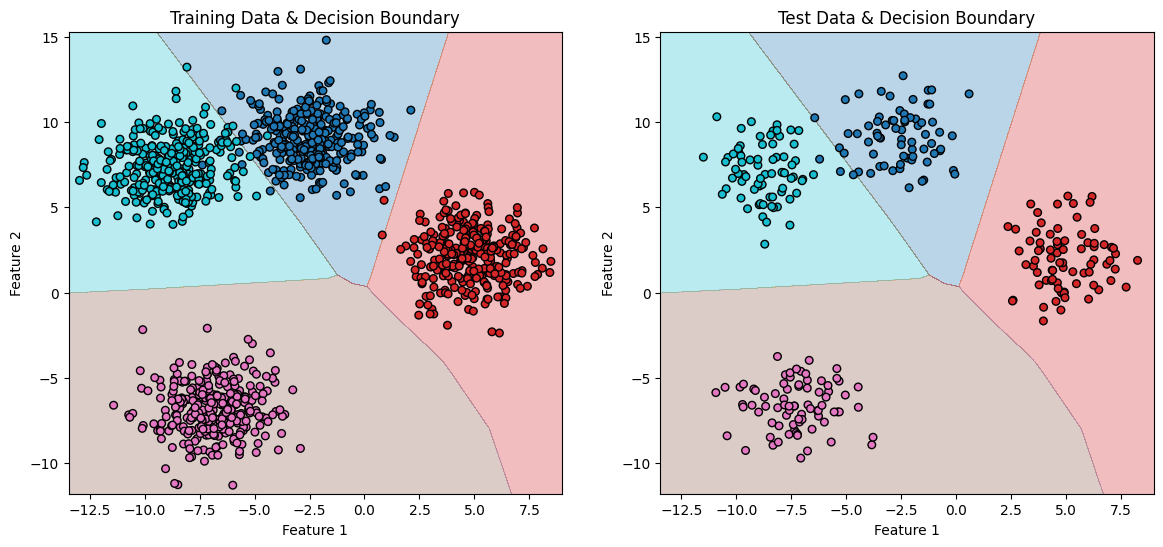

In [269]:
def plot_decision_boundary_subplots(model, X_train, y_train, X_test, y_test):
    model.eval()

    # Move data to device
    X_train, y_train = X_train.to(device), y_train.to(device)
    X_test, y_test = X_test.to(device), y_test.to(device)

    # Common min and max for both plots to have consistent axes
    x_min = min(X_train[:, 0].min(), X_test[:, 0].min()) - 0.5
    x_max = max(X_train[:, 0].max(), X_test[:, 0].max()) + 0.5
    y_min = min(X_train[:, 1].min(), X_test[:, 1].min()) - 0.5
    y_max = max(X_train[:, 1].max(), X_test[:, 1].max()) + 0.5
    step = 0.01

    # Create mesh grid
    xx, yy = np.meshgrid(
        np.arange(x_min.cpu().numpy(), x_max.cpu().numpy(), step),
        np.arange(y_min.cpu().numpy(), y_max.cpu().numpy(), step)
    )
    grid = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).type(torch.float).to(device)

    with torch.inference_mode():
        logits_train = model(grid)
        preds = torch.softmax(logits_train, dim=1).argmax(dim=1).cpu().numpy().reshape(xx.shape)

    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Training Data Plot
    ax1.contourf(xx, yy, preds, alpha=0.3, cmap='tab10')
    scatter1 = ax1.scatter(X_train[:, 0].cpu(), X_train[:, 1].cpu(), c=y_train.cpu(), cmap='tab10', edgecolor='k', s=30)
    ax1.set_title("Training Data & Decision Boundary")
    ax1.set_xlabel("Feature 1")
    ax1.set_ylabel("Feature 2")

    # Test Data Plot
    ax2.contourf(xx, yy, preds, alpha=0.3, cmap='tab10')
    ax2.scatter(X_test[:, 0].cpu(), X_test[:, 1].cpu(), c=y_test.cpu(), cmap='tab10', edgecolor='k', s=30)
    ax2.set_title("Test Data & Decision Boundary")
    ax2.set_xlabel("Feature 1")
    ax2.set_ylabel("Feature 2")
    
    plt.show()

# Call the function
plot_decision_boundary_subplots(model, X_blob_train, y_blob_train, X_blob_test, y_blob_test)